# Setup

In [1]:
%pip install git+https://github.com/MeteSertkan/ranger.git

  Cloning https://github.com/MeteSertkan/ranger.git to /private/var/folders/st/gn405qv15296zzdy6ww89vz80000gn/T/pip-req-build-52lk58n5
  Running command git clone --filter=blob:none --quiet https://github.com/MeteSertkan/ranger.git /private/var/folders/st/gn405qv15296zzdy6ww89vz80000gn/T/pip-req-build-52lk58n5
  Resolved https://github.com/MeteSertkan/ranger.git to commit 171134191cfa76255492893508ae7c089dc3d448
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/terrierteam/ir_measures.git (to revision 9460896) to /private/var/folders/st/gn405qv15296zzdy6ww89vz80000gn/T/pip-install-ynf2oxjw/ir-measures_710c282bb4ab435b87c6b60ce5c0e388
  Running command git clone --filter=blob:none --quiet https://github.com/terrierteam/ir_measures.git /private/var/folders/st/gn405qv15296zzdy6ww89vz80000gn/T/pip-install-ynf2oxjw/ir-measures_710c282bb4ab435b87c6b60ce5c0e388
  Running command git checkout -q 9460896
  Resolved https://github.com/terrierteam/ir_measures.git to commit 946

In [2]:
import os
import csv
import numpy as np
from ranger.metric_containers import AggregatedPairedMetrics, AggregatedMetrics
from ranger.meta_analysis import analyze_effects
from ranger.forest_plots import forest_plot

# Load the Runs

In [3]:
models = ["MF", "MF-bias", "BPR"]
datasets = ["amazon-clothing",
            "amazon-digital-music", 
            "amazon-office", 
            "amazon-toy", 
            "filmtrust", 
            "movielens-10M",
            "netflix-small"]

In [4]:
class Experiment:
    def __init__(self):
        self.rmse = AggregatedMetrics()
        self.ndcg = AggregatedMetrics()

In [5]:
def process_experiment_files(dir_path, model_names, dataset_names):
    experiments = {}

    for model_name in model_names:
        for dataset_name in dataset_names:
            filename = f"{model_name}_{dataset_name}.csv"
            file_path = os.path.join(dir_path, filename)

            if not os.path.isfile(file_path):
                raise FileNotFoundError(f"File '{filename}' not found!")

            if model_name not in experiments:
                experiments[model_name] = Experiment()

            experiment = experiments[model_name]

            with open(file_path, 'r') as file:
                csv_reader = csv.reader(file)
                next(csv_reader)  # Skip the header row
                rmse = []
                ndcg = []
                for row in csv_reader:
                    if len(row) >= 3:
                        rmse.append(float(row[1]) if row[1] else 0.0)
                        ndcg.append(float(row[2]) if row[2] else 0.0)
                experiment.rmse.add(rmse)
                experiment.ndcg.add(ndcg)

    return experiments

In [6]:
experiments = process_experiment_files(
    "runs", 
    models, 
    datasets)
    

# MF vs. MF-bias
In our first case study, we examine the impact of incorporating bias terms (user, item, and global) - designated as the treatment - against a basic matrix factorization model - the control. We measure their performance on user-item-rating matrix completion via RMSE and ranking through NDCG@10.
## RMSE


In [7]:
title = "MF vs. MF-bias"

In [8]:
effects = AggregatedPairedMetrics(
    treatment=experiments["MF-bias"].rmse.get_metrics(),
    control=experiments["MF"].rmse.get_metrics()
)

In [9]:
effect_size = analyze_effects(datasets,
                              effects=effects,
                              effect_type="SMD")

In [10]:
effect_size

,eff,ci_low,ci_upp,p,w_re
amazon-clothing,-3.077933,-3.273481,-2.882384,0.000000e+00,0.115094
amazon-digital-music,-0.145250,-0.162494,-0.128006,0.000000e+00,0.147958
amazon-office,-0.578521,-0.621275,-0.535768,0.000000e+00,0.146273
amazon-toy,-0.556238,-0.573282,-0.539194,0.000000e+00,0.147966
filmtrust,-0.222639,-0.266003,-0.179275,0.000000e+00,0.146216
movielens-10M,-0.030320,-0.031711,-0.028928,0.000000e+00,0.148288
netflix-small,-0.050401,-0.059129,-0.041674,0.000000e+00,0.148205
combined_effect,-0.587187,-0.727401,-0.446973,2.220446e-16,1.000000


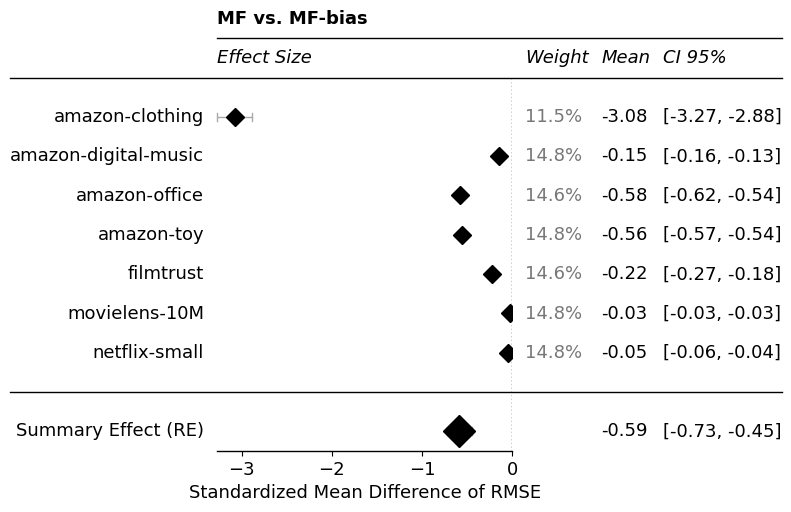

In [11]:
plot = forest_plot(
    title=title,
    experiment_names=datasets,
    label_x_axis="Standardized Mean Difference of RMSE",
    effect_size=effect_size,
    fig_width=8,
    fig_height=8 # higher height because we have many (7) test sets
)

All confidence intervals (CI) lie on the left of the zero-effect (dotted) line, with none crossing it, suggesting that the use of bias terms consistently and significantly improves matrix completion performance (smaller error). 
Notably, nearly all experiments contribute similarly to the overall effect calculation, except for the 'amazon-clothing' dataset, which shows a less confident effect estimation.
This reflects the inverse relationship between the variance of an experiment's effect-size and its weight in calculating the summary effect. 

In [12]:
fig_name = "mf_vs_mf-bias_rmse"
# save as pdf for latex integration
plot.savefig(fname=fig_name+".pdf", dpi=300, bbox_inches='tight')

# NDCG

In [13]:
title = "MF vs. MF-bias"

In [14]:
effects = AggregatedPairedMetrics(
    treatment=experiments["MF-bias"].ndcg.get_metrics(),
    control=experiments["MF"].ndcg.get_metrics()
)

In [15]:
effect_size = analyze_effects(datasets,
                              effects=effects,
                              effect_type="MD")

In [16]:
effect_size

,eff,ci_low,ci_upp,p,w_re
amazon-clothing,-0.026760,-0.033196,-0.020323,4.440892e-16,0.107380
amazon-digital-music,-0.008537,-0.010142,-0.006932,0.000000e+00,0.158909
amazon-office,-0.000434,-0.001242,0.000375,2.930711e-01,0.162775
amazon-toy,-0.008101,-0.009108,-0.007094,0.000000e+00,0.162036
filmtrust,-0.048758,-0.057333,-0.040182,0.000000e+00,0.084681
movielens-10M,-0.001074,-0.001523,-0.000625,2.719976e-06,0.163711
netflix-small,-0.000911,-0.002241,0.000419,1.795993e-01,0.160508
combined_effect,-0.010064,-0.013651,-0.006477,3.808665e-08,1.000000


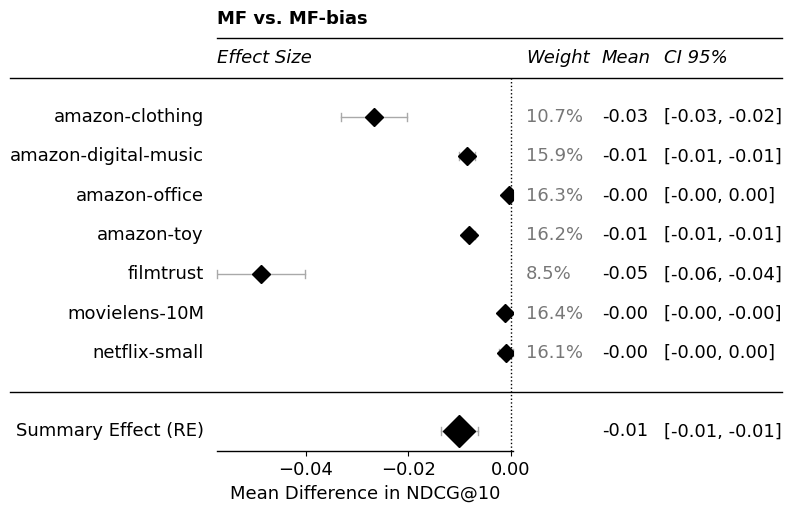

In [17]:
plot = forest_plot(
    title=title,
    experiment_names=datasets,
    label_x_axis="Mean Difference in NDCG@10",
    effect_size=effect_size,
    fig_width=8,
    fig_height=8 # higher height because we have many (7) test sets
)

Regarding ranking performance, we generally observe a decline when bias terms are introduced, suggesting potential overfitting.
While introducing bias terms enhance matrix completion, it seems to negatively impact ranking performance.
Notably, for individual experiments using 'amazon-office' and 'netflix-small' datasets, we find no significant ranking performance differences, as their corresponding confidence intervals cross the zero-effect line.

In [18]:
fig_name = "mf_vs_mf-bias_ndcg@10"
# save as pdf for latex integration
plot.savefig(fname=fig_name+".pdf", dpi=300, bbox_inches='tight')

# MF vs. BPR
In our second case study, we evaluate the effect of using Bayesian probabilistic ranking (BPR) - treatment - versus matrix factorization (MF) - control - on ranking performance (NDCG@10).
This comparison is conducted across all datasets, as well as exclusively on movie and retail datasets.
## All Datasets

In [19]:
title = "MF vs. BPR"

In [20]:
effects = AggregatedPairedMetrics(
    treatment=experiments["BPR"].ndcg.get_metrics(),
    control=experiments["MF"].ndcg.get_metrics()
)

In [21]:
effect_size = analyze_effects(datasets,
                              effects=effects,
                              effect_type="MD")

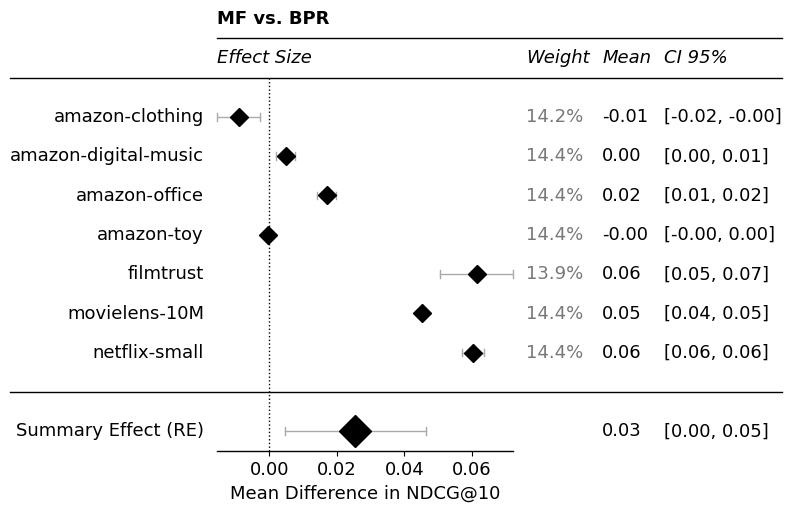

In [22]:
plot = forest_plot(
    title=title,
    experiment_names=datasets,
    label_x_axis="Mean Difference in NDCG@10",
    effect_size=effect_size,
    fig_width=8,
    fig_height=8 # higher height because we have many (7) test sets
)

Looking at the summary effect, we generally expect a boost in ranking performance when choosing BPR over MF.
Although the summary effect estimate is less certain than in the prior meta-analysis, it is still significant.
The difference in ranking performance between individual experiments with retail and movie datasets is immediately noticeable.

In [23]:
fig_name = "mf_vs_bpr_ndcg@10"
# save as pdf for latex integration
plot.savefig(fname=fig_name+".pdf", dpi=300, bbox_inches='tight')

# Retail Only Datasets

In [30]:
models = ["MF", "BPR"]
datasets = ["amazon-clothing",
            "amazon-digital-music", 
            "amazon-office", 
            "amazon-toy",]

In [31]:
experiments = process_experiment_files(
    "runs", 
    models, 
    datasets)

In [32]:
title = "MF vs. BPR"

In [33]:
effects = AggregatedPairedMetrics(
    treatment=experiments["BPR"].ndcg.get_metrics(),
    control=experiments["MF"].ndcg.get_metrics()
)

In [34]:
effect_size = analyze_effects(datasets,
                              effects=effects,
                              effect_type="MD")

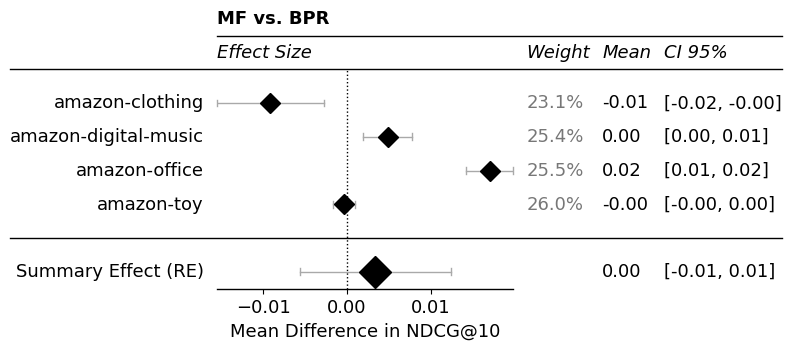

In [35]:
plot = forest_plot(
    title=title,
    experiment_names=datasets,
    label_x_axis="Mean Difference in NDCG@10",
    effect_size=effect_size,
    fig_width=8,
    fig_height=8 # higher height because we have many (7) test sets
)

Focusing on retail data only, we expect a performance decline for 'amazon-clothing', no significant difference for 'amazon-toy', and performance gains for 'amazon-digital-music' and 'amazon-office'.
On the whole, we do not expect significant differences when choosing BPR over MF for retail datasets.

In [36]:
fig_name = "mf_vs_bpr_ndcg@10_retail"
# save as pdf for latex integration
plot.savefig(fname=fig_name+".pdf", dpi=300, bbox_inches='tight')

## Movie Datasets Only

In [37]:
models = ["MF", "BPR"]
datasets = ["filmtrust", 
            "movielens-10M",
            "netflix-small"]

In [38]:
experiments = process_experiment_files(
    "runs", 
    models, 
    datasets)

In [39]:
title = "MF vs. BPR"

In [40]:
effects = AggregatedPairedMetrics(
    treatment=experiments["BPR"].ndcg.get_metrics(),
    control=experiments["MF"].ndcg.get_metrics()
)

In [41]:
effect_size = analyze_effects(datasets,
                              effects=effects,
                              effect_type="MD")

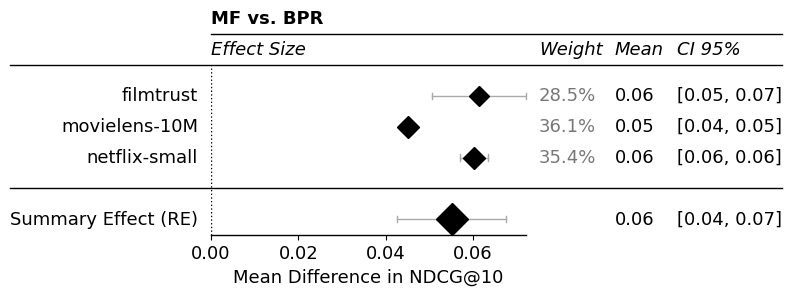

In [42]:
plot = forest_plot(
    title=title,
    experiment_names=datasets,
    label_x_axis="Mean Difference in NDCG@10",
    effect_size=effect_size,
    fig_width=8,
    fig_height=8 # higher height because we have many (7) test sets
)

In contrast, for movie datasets, we expect consistent and significant improvements in ranking performance when employing BPR.

In [43]:
fig_name = "mf_vs_bpr_ndcg@10_movie"
# save as pdf for latex integration
plot.savefig(fname=fig_name+".pdf", dpi=300, bbox_inches='tight')